# **Improving Training of Neural Networks**

In this notebook, we introduce some of the most common techniques used to improve the training of deep neural networks and help prevent overfitting. These methods make training more stable, lead to better generalization to unseen data, and can be especially helpful when working with imbalanced or limited datasets.

We will continue working with the **Adult dataset** from the UCI repository, which we previously explored and modeled. This dataset involves predicting whether an individual's income exceeds $50K/year based on census data, and it presents common challenges such as class imbalance and noisy features.

We will cover:

---

### 1. **Oversampling Techniques**

Oversampling addresses class imbalance by increasing the number of training samples from the minority class. This is crucial in classification tasks where one class (e.g., income > 50K) is underrepresented. We will explore:
- **Random Oversampling**: Simply duplicating examples from the minority class.
- **SMOTE (Synthetic Minority Over-sampling Technique)**: Generating synthetic examples by interpolating between existing minority class samples.

---

### 2. **Loss Regularization**

Loss regularization penalizes model complexity to prevent overfitting. We will examine:
- **L2 Regularization (Ridge)**: Adds a penalty equal to the square of the weights. Encourages small, distributed weights.

---

### 3. **Early Stopping**

Training a neural network for too many epochs can lead to overfitting. Early stopping is a simple and effective method to prevent this. We monitor the validation loss and stop training when it no longer improves. This technique helps:
- Reduce overfitting
- Save computation time
- Automatically determine the optimal number of training epochs

---

### 4. **Dropout**

Dropout is a regularization technique that randomly "drops" units (sets their output to zero) during training. This prevents co-adaptation of neurons and encourages the network to learn redundant, distributed representations. We will:
- Apply dropout to the hidden layers of our model
- Experiment with different dropout rates
- Observe its effect on generalization and model robustness




In [1]:
# Import and install necessary libraries
!pip install torchsummary
!pip install imblearn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In this cell we load the Adult dataset from the UCI Machine Learning Repository. Details about the dataset can be found at [https://archive.ics.uci.edu/dataset/2/adult](https://archive.ics.uci.edu/dataset/2/adult). This dataset is commonly used to predict whether income exceeds $50K/yr based on census data. We start by reading the data into a DataFrame, displaying its initial shape, and handling missing values. We then categorize the features into 'categorical' and 'continuous' types for future preprocessing steps.


In [2]:
#IMPORT AND PREPARE DATA

#read data into pandas dataframe
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]
data = pd.read_csv(url, names=columns, na_values="?", skipinitialspace=True)
print(data.shape)

# Drop missing values
data.dropna(inplace=True)
print(data.shape)

# Separate categorical and continuous features
categorical_features = [col for col in data.columns if data[col].dtype == "object"]
continuous_features = [col for col in data.columns if col not in categorical_features]

(32561, 15)
(30162, 15)


This block is dedicated to exploratory data analysis (EDA). EDA is crucial to understand the underlying patterns and anomalies in the data. We use histograms to visualize the distribution of continuous features and count plots for categorical features, providing insights into the dataset's structure and composition. We also compute and visualize the correlation matrix to identify potential relationships between features.


Histograms for continuous features



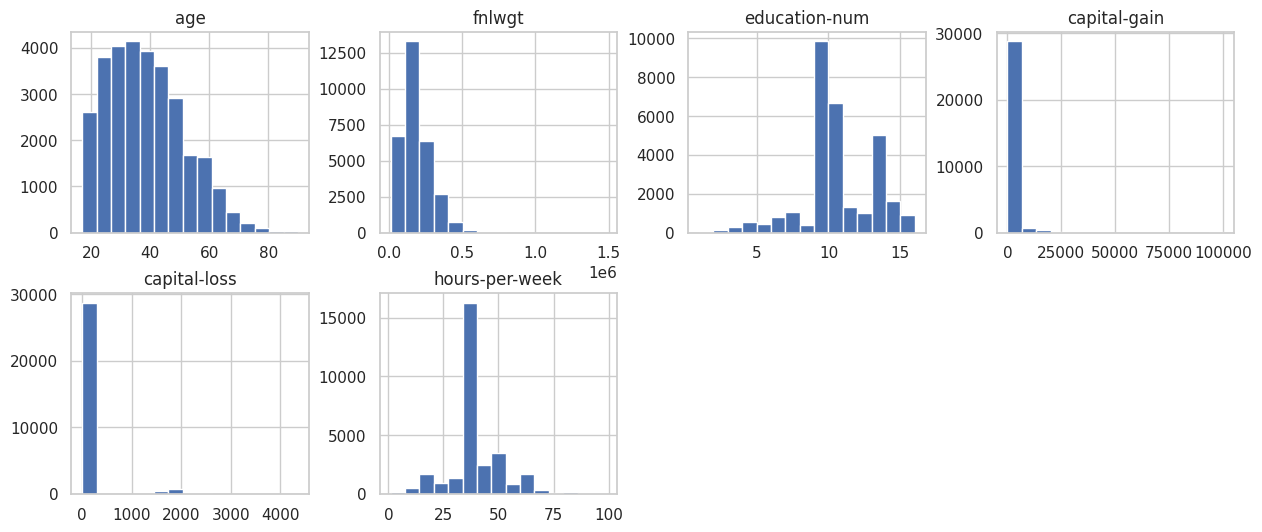

Count plots for categorical features



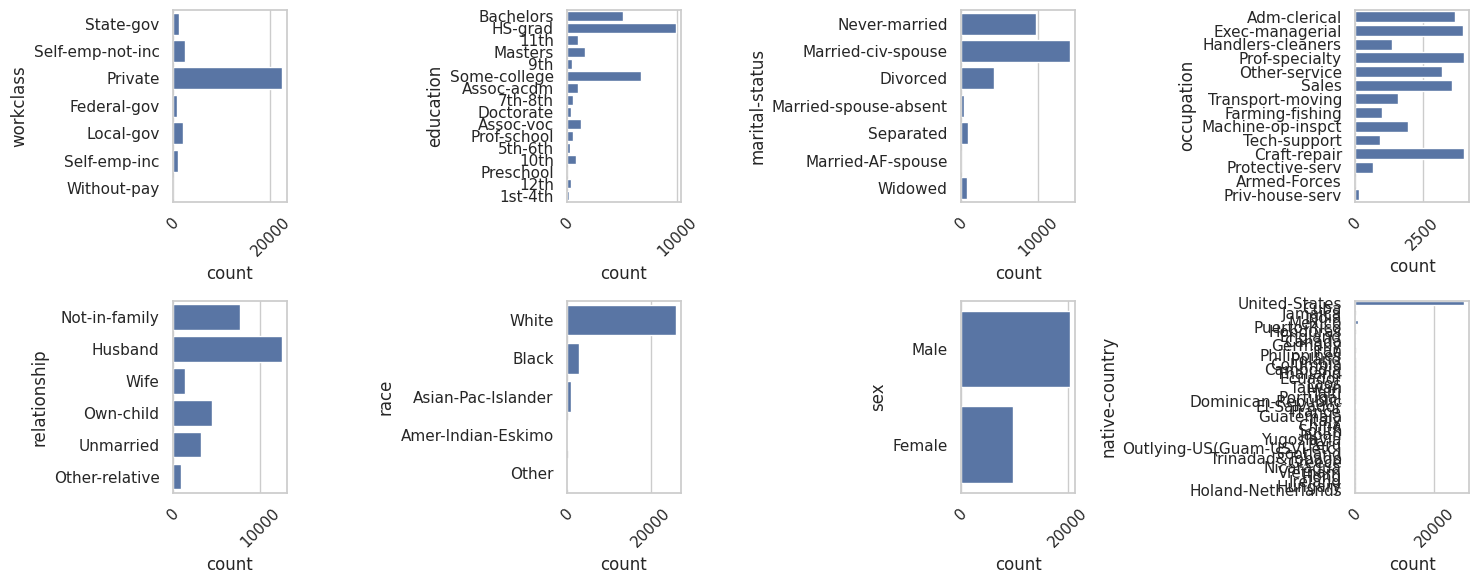

Correlation matrix



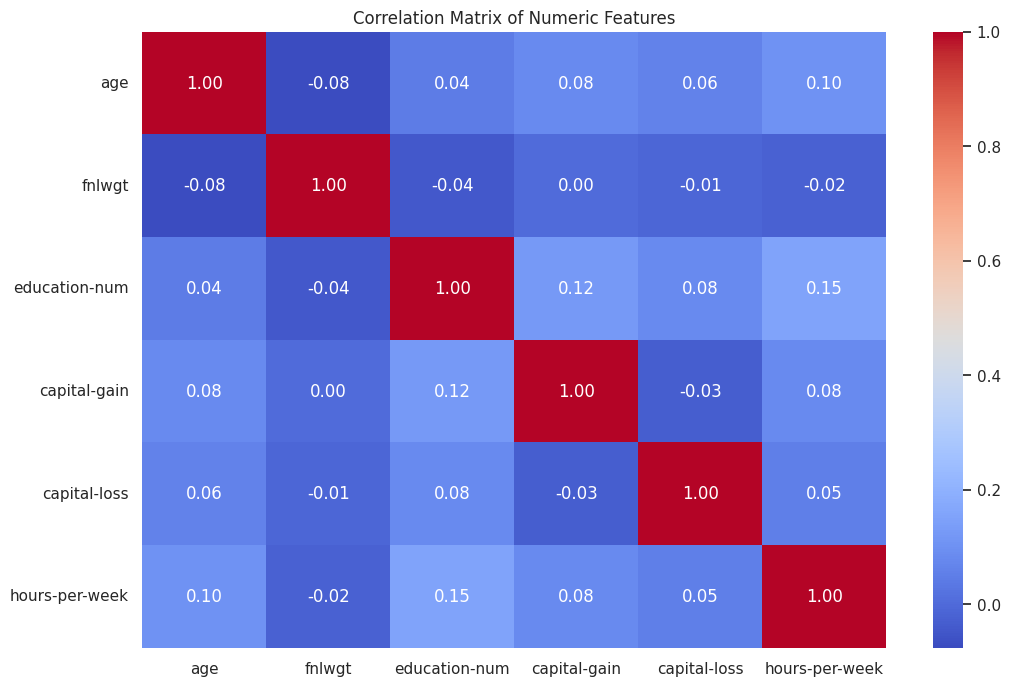

Class imbalance visualization



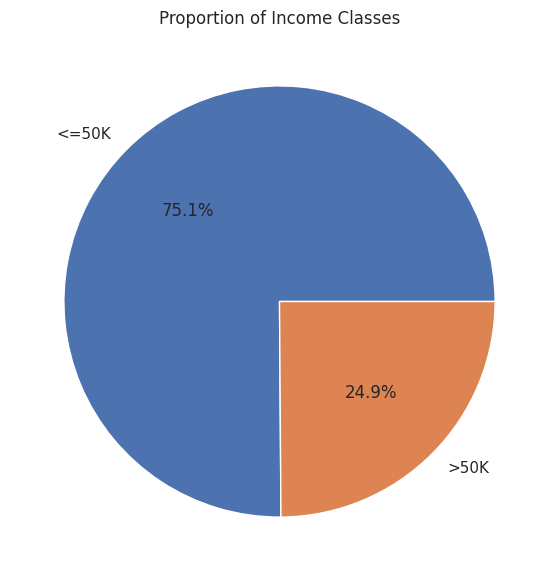

In [3]:
#ESPLORATORY DATA ANALYSIS
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for better visibility
sns.set(style="whitegrid")

# Histograms for continuous features
print('Histograms for continuous features\n')
data[continuous_features].hist(bins=15, figsize=(15, 6), layout=(2, 4))
plt.show()


# Count plots for categorical features
print('Count plots for categorical features\n')
fig, ax = plt.subplots(2, 4, figsize=(15, 6))  # Adjust shape according to number of categorical features
for var, subplot in zip(categorical_features[:-1], ax.flatten()):
    sns.countplot(data[var], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(45)
plt.tight_layout()
plt.show()

# Exclude non-numeric columns and compute the correlation matrix
numeric_data = data.select_dtypes(include=[np.number])  # This only includes numeric columns
corr_matrix = numeric_data.corr()

# Plot the correlation matrix
print('Correlation matrix\n')
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Pie chart for proportion of classes
print('Class imbalance visualization\n')
plt.figure(figsize=(7, 7))
data['income'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Proportion of Income Classes')
plt.ylabel('')
plt.show()

This section applies Principal Component Analysis (PCA) to reduce the dataset's dimensionality to two principal components. This transformation is performed to visualize the data in a two-dimensional space, making it easier to observe how distinct the data clusters are with respect to the target variable 'income'. We then plot these two components, coloring the points based on the income categories, to visually assess the separability of the income classes in this reduced space.


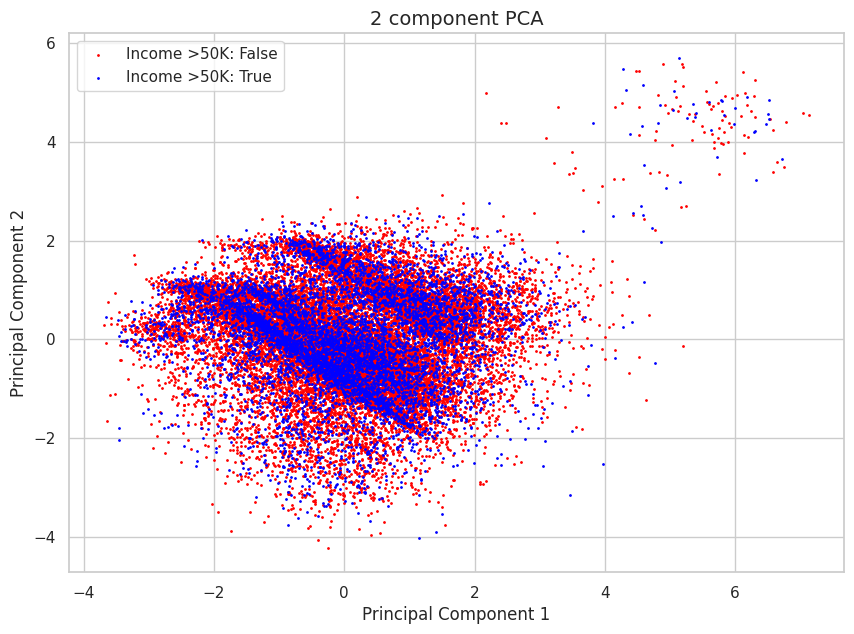

In [4]:
#PCA VISUALIZATION
from sklearn.decomposition import PCA


# Encode categorical variables
data_cat = pd.get_dummies(data, columns=[col for col in categorical_features])

# Scale continuous features only
scaler = StandardScaler()
data_cat[continuous_features] = scaler.fit_transform(data_cat[continuous_features])

# Convert boolean columns to integer
for col in data_cat.columns:
    if data_cat[col].dtype == bool:
        data_cat[col] = data_cat[col].astype(int)

# Prepare features and labels before splitting
features = data_cat.drop(['income_<=50K', 'income_>50K'], axis=1)
labels = data_cat['income_>50K']


# Convert features to a numpy array if not already
features_array = features.values
labels_array = labels.values

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_array)


# Create DataFrames for the results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add the target variable to these dataframes for plotting
pca_df['Income'] = labels

# Plotting by income category
# Setup figure and axes
fig, axes = plt.subplots(1, 1, figsize=(10, 7))

# Colors and income categories
colors = ['red', 'blue']
income_categories = [False, True]

# Plot PCA
for income, color in zip(income_categories, colors):
    indicesToKeep = pca_df['Income'] == income
    axes.scatter(pca_df.loc[indicesToKeep, 'PC1'],
                    pca_df.loc[indicesToKeep, 'PC2'],
                    c=color,
                    s=1,
                    label=f'Income >50K: {income}')
axes.set_xlabel('Principal Component 1', fontsize=12)
axes.set_ylabel('Principal Component 2', fontsize=12)
axes.set_title('2 component PCA', fontsize=14)
axes.legend(loc='best')
axes.grid(True)

# Display the plot
plt.show()

In this section, we preprocess the data by encoding categorical variables using one-hot encoding and scaling the continuous features to standardize the data, making it suitable for model training. We then split the data into training, validation, and test sets to ensure proper evaluation and validation of our models during training.
Due to class imbalance, we may apply oversampling techniques to the training data to improve model performance. We demonstrate how to use both SMOTE and Random Oversampling methods to balance the class distribution, which helps prevent our model from being biased toward the majority class. This dataset is not very imbalanced, but try experimenting a bit.


In [5]:
#TRAIN TEST VALIDATION SPLIT, OVERSAMPLING

import torch
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler

def prepare_data(features_array, labels_array, oversample=False, oversample_type='smote'):
    # Split data into training and test sets first
    X_train_val, X_test, y_train_val, y_test = train_test_split(features_array, labels_array, test_size=0.2, random_state=42)

    # Split the training set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

    # Apply oversampling to the training data if requested
    if oversample:
        if oversample_type == 'smote':
            smote = SMOTE(random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train)
        elif oversample_type == 'random':
            ros = RandomOverSampler(random_state=42)
            X_train, y_train = ros.fit_resample(X_train, y_train)

    # Convert resampled training data, validation data, and test data to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor

X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor = prepare_data(features_array,
                                                                                                        labels_array,
                                                                                                        oversample=False,
                                                                                                        oversample_type='smote')

Here, we establish benchmarks for our deep learning model by comparing its performance against traditional machine learning models: Logistic Regression and Random Forest. We first convert our tensors back to numpy arrays, which are required by Scikit-learn's API. After training each model on the training set, we evaluate them on the validation set to assess their accuracy and overall classification performance, including F1 scores. These benchmarks are crucial for understanding how well more complex models perform in comparison to more straightforward and interpretable models. Play with the model parameters to get the best performances on the validation set!


In [6]:
#BENCHMARKS

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,  f1_score, precision_recall_curve, confusion_matrix


X_train_np = X_train_tensor.numpy()
y_train_np = y_train_tensor.numpy()
X_test_np = X_test_tensor.numpy()
y_test_np = y_test_tensor.numpy()
X_val_np = X_val_tensor.numpy()
y_val_np = y_val_tensor.numpy()

# Train Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_np, y_train_np)

# Train Random Forest
random_forest_model = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=25)
random_forest_model.fit(X_train_np, y_train_np)

# Function to evaluate the classifier and find the best threshold for F1 score
def evaluate_classifier_for_best_threshold(classifier, X, y_true, y_scores=None, threshold=0):
    # Get the probability scores for the positive class
    if y_scores == None:
      y_scores = classifier.predict_proba(X)[:, 1]

    # Calculate precision-recall pairs for different probability thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    # Calculate F1 score for each threshold
    f1_scores = 2 * recall * precision / (recall + precision)
    # Find the index of the highest F1 score
    best_f1_index = np.argmax(f1_scores)
    if threshold == 0:
      best_threshold = thresholds[best_f1_index]
    else:
      best_threshold = threshold
    best_f1_score = f1_scores[best_f1_index]

    print(f"Best Threshold: {best_threshold:.4f}")
    print(f"Best F1 Score: {best_f1_score:.4f}")
    # Calculate accuracy and classification report using the best threshold
    y_pred = [1 if score >= best_threshold else 0 for score in y_scores]
    print(f"Accuracy:", accuracy_score(y_true, y_pred))
    print(f"Classification Report:\n", classification_report(y_true, y_pred, target_names=['<=50K', '>50K']))
    print(f"Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    return best_threshold, best_f1_score

# Evaluate the Logistic Regression classifier and find the best threshold
logistic_best_threshold, logreg_best_f1_score = evaluate_classifier_for_best_threshold(logistic_model, X_val_np, y_val_np)

# Evaluate the Random Forest classifier and find the best threshold
rf_best_threshold, rf_best_f1_score = evaluate_classifier_for_best_threshold(random_forest_model, X_val_np, y_val_np)



Best Threshold: 0.3888
Best F1 Score: 0.6992
Accuracy: 0.8455163268688878
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.91      0.89      0.90      4529
        >50K       0.68      0.72      0.70      1504

    accuracy                           0.85      6033
   macro avg       0.79      0.80      0.80      6033
weighted avg       0.85      0.85      0.85      6033

Confusion Matrix:
 [[4018  511]
 [ 421 1083]]
Best Threshold: 0.3918
Best F1 Score: 0.7175
Accuracy: 0.8538040775733466
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.91      0.89      0.90      4529
        >50K       0.69      0.74      0.72      1504

    accuracy                           0.85      6033
   macro avg       0.80      0.82      0.81      6033
weighted avg       0.86      0.85      0.86      6033

Confusion Matrix:
 [[4031  498]
 [ 384 1120]]


Here we define a Multilayer Perceptron (MLP) model using PyTorch. The MLP is a class of feedforward artificial neural network that consists of at least three layers of nodes: an input layer, a hidden layer, and an output layer. Each node, except for the input nodes, uses a nonlinear activation function. We'll use this model to classify individuals based on their income level. Try to modify the architecture, add more layers, change the activations, vary the number of neurons in each layer, include dropout(s) to prevent overfitting.


In [7]:
#MODEL ARCHITECTURE DEFINITION AND INITIALIZATION
from torchsummary import summary

# Define MLP for classification
class MLP_Classifier(nn.Module):
    def __init__(self):
        super(MLP_Classifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train_tensor.shape[1], 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model = MLP_Classifier().to(device)

#summary of model structure
summary(model, input_size=(X_train_tensor.shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 18096, 64]           6,720
              ReLU-2            [-1, 18096, 64]               0
           Dropout-3            [-1, 18096, 64]               0
            Linear-4             [-1, 18096, 8]             520
              ReLU-5             [-1, 18096, 8]               0
            Linear-6             [-1, 18096, 1]               9
           Sigmoid-7             [-1, 18096, 1]               0
Total params: 7,249
Trainable params: 7,249
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 7.18
Forward/backward pass size (MB): 28.99
Params size (MB): 0.03
Estimated Total Size (MB): 36.20
----------------------------------------------------------------


In this section, we define an Early Stopping class to prevent overfitting during the training of our neural network. Early stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method, such as gradient descent. This class monitors the validation loss as the model trains, and if the loss does not improve after a specified number of epochs (defined by the 'patience' parameter), it stops the training. Additionally, the class saves the model at its best performance state, allowing us to revert to the best model after training concludes.


In [8]:
#EARLY STOPPING

class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt', verbose=True):
        """
        Early stops the training if validation loss doesn't improve after a given patience.

        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path to save the model checkpoint.
            verbose (bool): If True, prints when saving a new best model.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model, epoch=None):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, epoch)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model, epoch)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model, epoch=None):
        '''Saves model when validation loss decreases.'''
        torch.save(model.state_dict(), self.path)
        if self.verbose:
            if epoch is not None:
                print(f"Epoch {epoch+1}: Validation loss improved --> {val_loss:.6f}. Saving model...")
            else:
                print(f"Validation loss improved --> {val_loss:.6f}. Saving model...")




In this block, we handle the training process of our MLP model. Training is conducted over multiple epochs, where the model learns to predict the training data's outcomes accurately. We also utilize a validation set to monitor the model's performance and apply early stopping to prevent overfitting.

Epoch: 1, Training Loss: 0.6934, Validation Loss: 0.6499
Epoch 1: Validation loss improved --> 0.649881. Saving model...
Epoch: 2, Training Loss: 0.5989, Validation Loss: 0.5490
Epoch 2: Validation loss improved --> 0.549016. Saving model...
Epoch: 3, Training Loss: 0.5069, Validation Loss: 0.4699
Epoch 3: Validation loss improved --> 0.469948. Saving model...
Epoch: 4, Training Loss: 0.4399, Validation Loss: 0.4143
Epoch 4: Validation loss improved --> 0.414322. Saving model...
Epoch: 5, Training Loss: 0.3957, Validation Loss: 0.3794
Epoch 5: Validation loss improved --> 0.379432. Saving model...
Epoch: 6, Training Loss: 0.3691, Validation Loss: 0.3603
Epoch 6: Validation loss improved --> 0.360254. Saving model...
Epoch: 7, Training Loss: 0.3554, Validation Loss: 0.3499
Epoch 7: Validation loss improved --> 0.349929. Saving model...
Epoch: 8, Training Loss: 0.3460, Validation Loss: 0.3437
Epoch 8: Validation loss improved --> 0.343734. Saving model...
Epoch: 9, Training Loss: 0.3414,

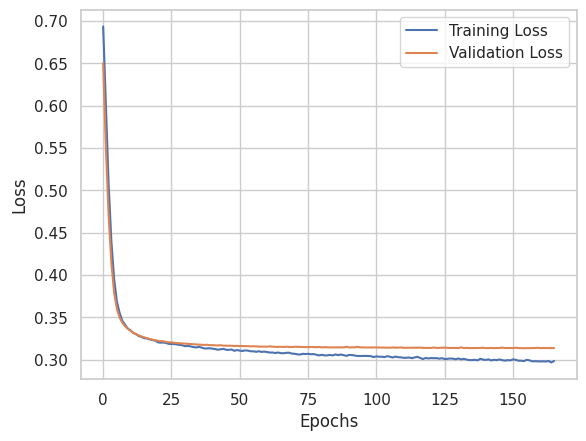

In [9]:
#MODEL TRAINING

#hyperparameter
L2_reg = 0.0001
lr = 0.0001
batch_size = 128

#training parameters
patience = 25
epochs = 500

#training model function
def train_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        batch_train_losses = []

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.view(-1, 1))
            loss.backward()
            optimizer.step()
            batch_train_losses.append(loss.item())

        mean_train_loss = np.mean(batch_train_losses)
        train_losses.append(mean_train_loss)

        model.eval()
        batch_val_losses = []
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss = criterion(output, target.view(-1, 1))
                batch_val_losses.append(val_loss.item())

        mean_val_loss = np.mean(batch_val_losses)
        val_losses.append(mean_val_loss)

        # Now, print and early stopping based on mean_val_loss
        print(f'Epoch: {epoch+1}, Training Loss: {mean_train_loss:.4f}, Validation Loss: {mean_val_loss:.4f}')

        early_stopper(mean_val_loss, model, epoch)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load(early_stopper.path))
    return train_losses, val_losses


# Create TensorDatasets and DataLoaders for Training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Loss Function
class_counts = data_cat['income_>50K'].value_counts().sort_index().values
class_weights = [sum(class_counts) / c for c in class_counts]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
#criterion = nn.BCELoss(weight=class_weights_tensor[0])
criterion = nn.BCELoss()

# Instantiate optimizer and early stopper
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=L2_reg)  # L2 Regularization
early_stopper = EarlyStopping(patience=patience)

# Run training and plot losses
train_losses, val_losses = train_model(epochs, model, optimizer, criterion, train_loader, test_loader, early_stopper)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Post-training, we evaluate the MLP model using the validation set to check its generalization capability. We compute various performance metrics like accuracy and F1 score, and visualize the results using a confusion matrix. This helps in understanding how well the model is performing and where it might be making errors. Go back and play with the model architecture and with the hyperparameters to find the best performing neural network.

In [ ]:
#EVALUATE MODEL ON VALIDATION SET

from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve

# Function to evaluate the model and find the best threshold for F1 score
def evaluate_model(data_loader, model=model, threshold=0):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_scores = []

    # Collect all labels and model outputs
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_scores.extend(output.view(-1).cpu().numpy())  # Store raw model outputs
            y_true.extend(target.cpu().numpy())


    # Calculate precision-recall pairs for different probability thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    # Calculate F1 score for each threshold
    f1_scores = 2 * recall * precision / (recall + precision)
    # Find the index of the highest F1 score
    best_f1_index = np.argmax(f1_scores)
    if threshold == 0:
      best_threshold = thresholds[best_f1_index]
    else:
      best_threshold = threshold
    best_f1_score = f1_scores[best_f1_index]

    print(f"Best Threshold: {best_threshold:.4f}")
    print(f"Best F1 Score: {best_f1_score:.4f}")
    # Calculate accuracy and classification report using the best threshold
    y_pred = [1 if score >= best_threshold else 0 for score in y_scores]
    print("Multilayer Perceptron Accuracy:", accuracy_score(y_true, y_pred))
    print("Multilayer Perceptron Classification Report:\n", classification_report(y_true, y_pred, target_names=['<=50K', '>50K']))
    print("Multilayer Perceptron Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    return best_threshold, best_f1_score

# Call the function to evaluate the model and find the best threshold
mlp_best_threshold, mlp_best_f1_score = evaluate_model(val_loader)

Best Threshold: 0.4043
Best F1 Score: 0.7098
Multilayer Perceptron Accuracy: 0.8489971821647605
Multilayer Perceptron Classification Report:
               precision    recall  f1-score   support

       <=50K       0.91      0.88      0.90      4529
        >50K       0.68      0.74      0.71      1504

    accuracy                           0.85      6033
   macro avg       0.80      0.81      0.80      6033
weighted avg       0.85      0.85      0.85      6033

Multilayer Perceptron Confusion Matrix:
 [[4008  521]
 [ 390 1114]]


Finally, we compare the performance of our best MLP model against traditional machine learning models such as Logistic Regression and Random Forest. This comparison is crucial to evaluate the effectiveness of deep learning models against conventional approaches on this specific dataset. Use the test set only after having spent some time tuning the hyperparameters (also of the standard ML models) and the neural network architecture. **Once you test your models on the test set, you can't go back and modify them!**

In [ ]:
#COMPARE ALL MODELS ON TEST SET

# Predictions and Evaluations Logistic Model
print("--------------------------\nLOGISTIC MODEL\n--------------------------\n")
logistic_best_threshold, logistic_best_f1_score = evaluate_classifier_for_best_threshold(logistic_model,
                                                                                         X_test_np,
                                                                                         y_test_np,
                                                                                         threshold=logistic_best_threshold)

# Predictions and Evaluations Random Forest
print("\n--------------------------\nRANDOM FOREST\n--------------------------\n")
rf_best_threshold, rf_best_f1_score = evaluate_classifier_for_best_threshold(random_forest_model,
                                                                             X_test_np,
                                                                             y_test_np,
                                                                             threshold=rf_best_threshold)


# Predictions and Evaluations Multilayer Perceptron
print("\n--------------------------\nMULTILAYER PERCEPTRON\n--------------------------\n")
mlp_best_threshold, mlp_best_f1_score = evaluate_model(test_loader, threshold=mlp_best_threshold)



--------------------------
LOGISTIC MODEL
--------------------------

Best Threshold: 0.3888
Best F1 Score: 0.7005
Accuracy: 0.8415382065307475
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.90      0.89      0.89      4503
        >50K       0.68      0.71      0.69      1530

    accuracy                           0.84      6033
   macro avg       0.79      0.80      0.79      6033
weighted avg       0.84      0.84      0.84      6033

Confusion Matrix:
 [[3992  511]
 [ 445 1085]]

--------------------------
RANDOM FOREST
--------------------------

Best Threshold: 0.3918
Best F1 Score: 0.7234
Accuracy: 0.8534725675451682
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.91      0.89      0.90      4503
        >50K       0.70      0.75      0.72      1530

    accuracy                           0.85      6033
   macro avg       0.80      0.82      0.81      6033
weighted avg       

# **Autoencoder**

An **Autoencoder** is a type of neural network trained to learn an efficient, compressed representation of input data (the **bottleneck**) and then reconstruct the original input from this compressed version. It consists of two main parts:
- **Encoder**: Maps the input data to a lower-dimensional latent space.
- **Decoder**: Attempts to reconstruct the input data from the compressed latent representation.

By training the network to minimize the **reconstruction error** — typically using a loss function like Mean Squared Error (MSE) — the Autoencoder learns a meaningful low-dimensional representation that captures important structures and patterns in the data.

Unlike traditional dimensionality reduction methods like PCA, which are limited to linear transformations, Autoencoders can model **complex, nonlinear relationships** between features, making them particularly powerful for high-dimensional datasets.

In this notebook, we will:
- Design and train a simple Autoencoder on our dataset.
- Reduce the feature space to **2 dimensions** by setting the bottleneck layer to size 2.
- Visualize the resulting 2D representations to see how the data is organized in the learned space.
- Compare the Autoencoder's embeddings with those obtained through **Principal Component Analysis (PCA)**.


First of all we define the autoencoder architecture. We use an hidden layer with 64 neurons and then a bottleneck with dimension 2. We then need to go back to the input dimension, so we place another hidden layer with 64 neurons and then an output layer with as many neuros as the input.

In [ ]:
#AUTOENCODER FOR NONLINEAR DIMENSIONALITY REDUCTION

# Define Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=2):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, bottleneck_dim)  # bottleneck (2D)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize Autoencoder
autoencoder = Autoencoder(input_dim=features.shape[1]).to(device)

# Define optimizer and loss function
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=1e-4)  # L2 Regularization
reconstruction_loss_fn = nn.MSELoss()

# Early stopper
autoencoder_early_stopper = EarlyStopping(patience=25)




Training the Autoencoder involves similar functions and procedure as a standard MLP. Since our goal is reconstructin, we should change the loss to MSE (or MAE). The rest of the functions and code are basically the same.

Epoch 1, Train Loss: 0.095029, Val Loss: 0.072574
Epoch 1: Validation loss improved --> 0.072574. Saving model...
Epoch 2, Train Loss: 0.068013, Val Loss: 0.059085
Epoch 2: Validation loss improved --> 0.059085. Saving model...
Epoch 3, Train Loss: 0.060902, Val Loss: 0.057338
Epoch 3: Validation loss improved --> 0.057338. Saving model...
Epoch 4, Train Loss: 0.059260, Val Loss: 0.056311
Epoch 4: Validation loss improved --> 0.056311. Saving model...
Epoch 5, Train Loss: 0.058227, Val Loss: 0.055486
Epoch 5: Validation loss improved --> 0.055486. Saving model...
Epoch 6, Train Loss: 0.057516, Val Loss: 0.054670
Epoch 6: Validation loss improved --> 0.054670. Saving model...
Epoch 7, Train Loss: 0.056986, Val Loss: 0.054089
Epoch 7: Validation loss improved --> 0.054089. Saving model...
Epoch 8, Train Loss: 0.056658, Val Loss: 0.053859
Epoch 8: Validation loss improved --> 0.053859. Saving model...
Epoch 9, Train Loss: 0.056269, Val Loss: 0.053647
Epoch 9: Validation loss improved --> 

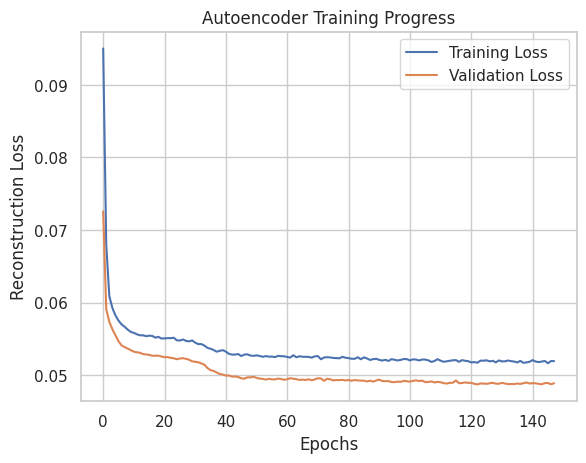

In [ ]:
# Train Autoencoder
def train_autoencoder(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        batch_train_losses = []

        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            batch_train_losses.append(loss.item())

        mean_train_loss = np.mean(batch_train_losses)
        train_losses.append(mean_train_loss)

        model.eval()
        batch_val_losses = []
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                output = model(data)
                val_loss = criterion(output, data)
                batch_val_losses.append(val_loss.item())

        mean_val_loss = np.mean(batch_val_losses)
        val_losses.append(mean_val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {mean_train_loss:.6f}, Val Loss: {mean_val_loss:.6f}")

        early_stopper(mean_val_loss, model, epoch)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load best model
    model.load_state_dict(torch.load(early_stopper.path))
    return train_losses, val_losses


# Train Autoencoder
autoencoder_train_losses, autoencoder_val_losses = train_autoencoder(epochs=500,
                                                                      model=autoencoder,
                                                                      optimizer=autoencoder_optimizer,
                                                                      criterion=reconstruction_loss_fn,
                                                                      train_loader=train_loader,
                                                                      val_loader=val_loader,
                                                                      early_stopper=autoencoder_early_stopper)

# Plot training and validation losses
plt.plot(autoencoder_train_losses, label='Training Loss')
plt.plot(autoencoder_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.title('Autoencoder Training Progress')
plt.show()

We can now use the Autoencoder we just trained to perform dimensionality reduction. For this task, we only need the encoder section of the autoencoder, that will be applied to the input data.

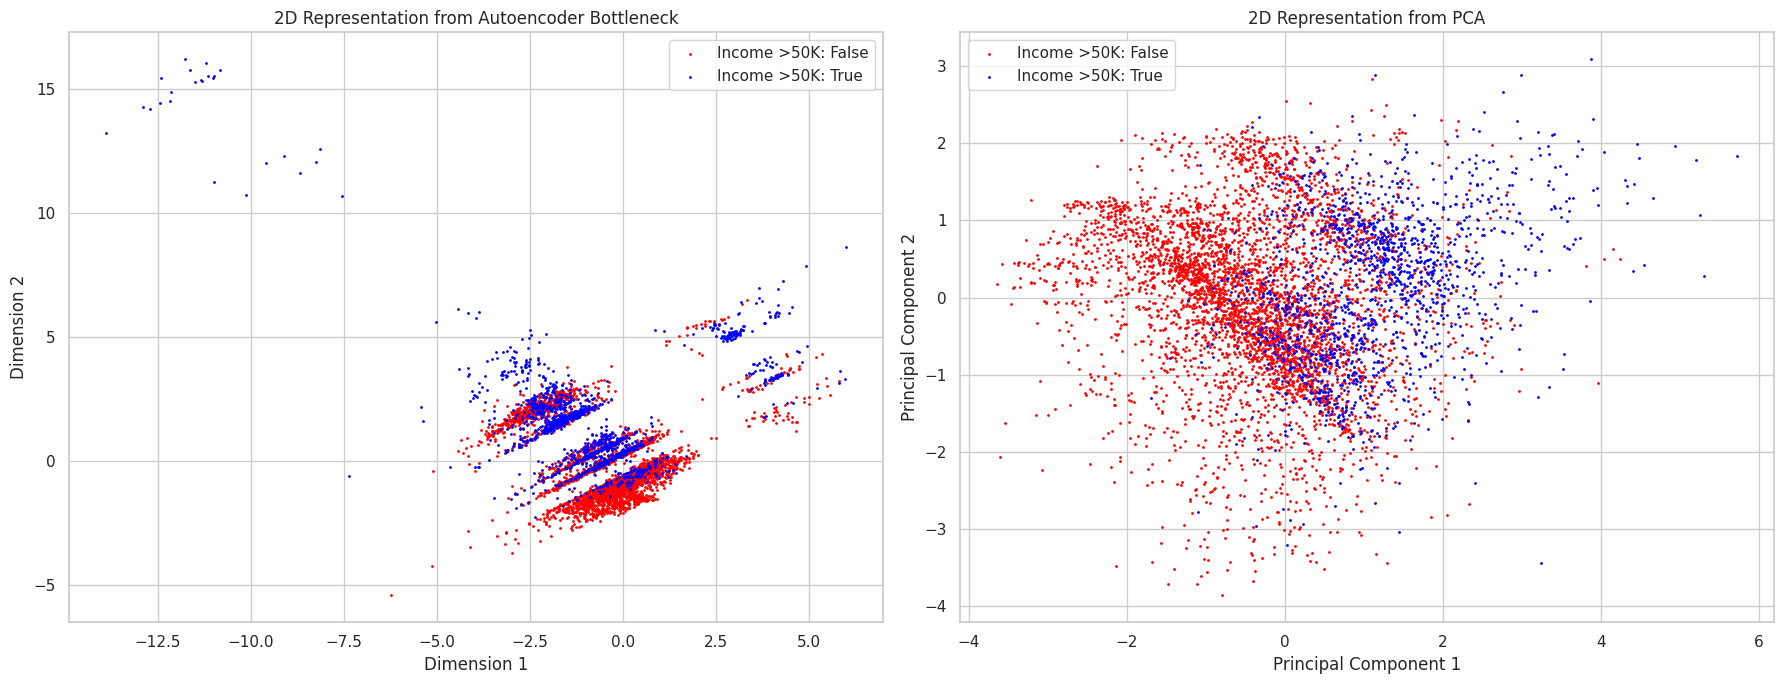

Silhouette Score on Autoencoder: 0.2238
Silhouette Score on PCA: 0.1580


In [ ]:
# PROJECT DATA TO BOTTLENECK SPACE AND COMPARE WITH PCA

# Project test data to autoencoder bottleneck
autoencoder.eval()
with torch.no_grad():
    X_test_encoded = autoencoder.encoder(X_test_tensor.to(device)).cpu().numpy()

# Create DataFrame for encoded data (Autoencoder)
encoded_df = pd.DataFrame(X_test_encoded, columns=['Dim1', 'Dim2'])
encoded_df['Income'] = y_test_np

# Project test data with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_test_np = X_test_tensor.cpu().numpy()  # Move to CPU if necessary
X_test_pca = pca.fit_transform(X_test_np)

# Create DataFrame for PCA results
pca_df = pd.DataFrame(X_test_pca, columns=['PC1', 'PC2'])
pca_df['Income'] = y_test_np

# Visualize both projections
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

colors = ['red', 'blue']
income_categories = [0, 1]

# Autoencoder Plot
for income, color in zip(income_categories, colors):
    indices = encoded_df['Income'] == income
    axes[0].scatter(encoded_df.loc[indices, 'Dim1'],
                    encoded_df.loc[indices, 'Dim2'],
                    c=color,
                    s=1,
                    label=f'Income >50K: {bool(income)}')

axes[0].set_xlabel('Dimension 1')
axes[0].set_ylabel('Dimension 2')
axes[0].set_title('2D Representation from Autoencoder Bottleneck')
axes[0].legend(loc='best')
axes[0].grid(True)

# PCA Plot
for income, color in zip(income_categories, colors):
    indices = pca_df['Income'] == income
    axes[1].scatter(pca_df.loc[indices, 'PC1'],
                    pca_df.loc[indices, 'PC2'],
                    c=color,
                    s=1,
                    label=f'Income >50K: {bool(income)}')

axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
axes[1].set_title('2D Representation from PCA')
axes[1].legend(loc='best')
axes[1].grid(True)

plt.tight_layout()
plt.show()




Finally we can test wheter the autoencoder is performing better than the PCA. Silhouette Score measures how well each point fits within its own class compared to other classes.
A high score means points are close to others of the same class and far from points of different classes.
It ranges from -1 (bad separation) to 1 (perfect separation), helping us evaluate the quality of the 2D projection.

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_autoencoder = silhouette_score(encoded_df[['Dim1', 'Dim2']], encoded_df['Income'])
silhouette_pca = silhouette_score(pca_df[['PC1', 'PC2']], pca_df['Income'])

Silhouette Score on Autoencoder: 0.2238
Silhouette Score on PCA: 0.1580
Accuracy on 2D Autoencoder bottleneck: 0.7432
Accuracy on 2D PCA projection: 0.8110
